In [ ]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [1]:
try:
    from modsim import *
except ImportError:
    print("Download modsim from the course repository at https://github.com/jeffwalton/AE470")

# The Circular Restricted Three-Body Problem (CR3BP)

## Development of the CR3BP

### Website of Byran Weber

[https://orbital-mechanics.space](https://orbital-mechanics.space)

   - [Circular Restricted Three-Body Problem](https://orbital-mechanics.space/the-n-body-problem/circular-restricted-three-body-problem.html)
   - [Lagrange Points](https://orbital-mechanics.space/the-n-body-problem/lagrange-points.html)
   - [Plotting Lagrange Points](https://orbital-mechanics.space/the-n-body-problem/Lagrange-points-example.html)
   - [The Jacobi Constant](https://orbital-mechanics.space/the-n-body-problem/jacobi-constant.html)
   - [CR3BP Equations of Motion](https://orbital-mechanics.space/the-n-body-problem/Equations-of-Motion-CR3BP.html)


### YouTube of Dr. Shane Ross

   - [3-Body Problem Equations Derived, Part 1: Inertial Frame and Non-dimensionalization](https://www.youtube.com/watch?v=-j6Fv_Pb5fk)
   - [3-Body Problem Equations Derived, Part 2: Rotating Frame](https://www.youtube.com/watch?v=i3CSBYHz00A)
   - [Lagrange Points L4, L5 in 3-Body Problem: Derivation of Equilateral Point Location](https://www.youtube.com/watch?v=CfWwmHI3BNQ)
   - [Calculating Collinear Lagrange Point Positions: L1, L2, L3 in Restricted 3-Body Problem](https://www.youtube.com/watch?v=_cqC6q7OfRk)




## References

    A.H.J. de Ruiter, C.J. Damaren, J.R. Forbes; Spacecraft Dynamics and Control: An Introduction; Wiley, 2013.

    Victor Szebehely; Theory of Orbits: The Restricted Problem of Three Bodies; Academic Press, Inc.; 1967.  



### Code from Bryan Weber

[Orbital Mechanics & Astrodynamics](https://orbital-mechanics.space) by Bryan Weber is licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

In [2]:
# These masses represent the Earth-Moon system
m_1 = 5.974e24  # kg
m_2 = 7.348e22  # kg
pi_2 = m_2 / (m_1 + m_2)

In [3]:
x_0 = 1 - pi_2
y_0 = 0.0455
z_0 = 0
vx_0 = -0.5
vy_0 = 0.5
vz_0 = 0

# Then stack everything together into the state vector
r_0 = np.array((x_0, y_0, z_0))
v_0 = np.array((vx_0, vy_0, vz_0))
Y_0 = np.hstack((r_0, v_0))

In [4]:
def nondim_cr3bp(t, Y):
    """Solve the CR3BP in nondimensional coordinates.

    The state vector is Y, with the first three components as the
    position of $m$, and the second three components its velocity.

    The solution is parameterized on $\\pi_2$, the mass ratio.
    """
    # Get the position and velocity from the solution vector
    x, y, z = Y[:3]
    xdot, ydot, zdot = Y[3:]

    # Define the derivative vector
    Ydot = np.zeros_like(Y)
    Ydot[:3] = Y[3:]

    sigma = np.sqrt(np.sum(np.square([x + pi_2, y, z])))
    psi = np.sqrt(np.sum(np.square([x - 1 + pi_2, y, z])))
    Ydot[3] = (
        2 * ydot
        + x
        - (1 - pi_2) * (x + pi_2) / sigma**3
        - pi_2 * (x - 1 + pi_2) / psi**3
    )
    Ydot[4] = -2 * xdot + y - (1 - pi_2) * y / sigma**3 - pi_2 * y / psi**3
    Ydot[5] = -(1 - pi_2) / sigma**3 * z - pi_2 / psi**3 * z
    return Ydot

In [5]:
t_0 = 0  # nondimensional time
t_f = 20  # nondimensional time
t_points = np.linspace(t_0, t_f, 1000)
sol = solve_ivp(nondim_cr3bp, [t_0, t_f], Y_0, t_eval=t_points)

Y = sol.y.T
r = Y[:, :3]  # nondimensional distance
v = Y[:, 3:]  # nondimensional velocity

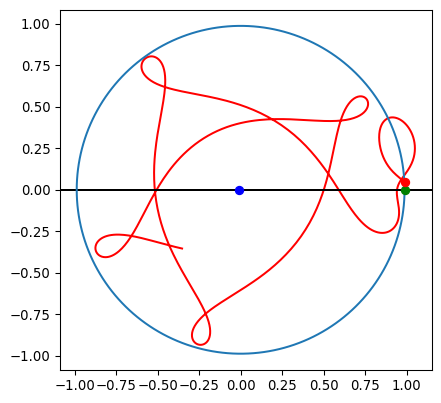

In [6]:
x_2 = (1 - pi_2) * np.cos(np.linspace(0, np.pi, 100))
y_2 = (1 - pi_2) * np.sin(np.linspace(0, np.pi, 100))
fig, ax = plt.subplots(figsize=(5, 5), dpi=96)

# Plot the orbits
ax.plot(r[:, 0], r[:, 1], "r", label="Trajectory")
ax.axhline(0, color="k")
ax.plot(np.hstack((x_2, x_2[::-1])), np.hstack((y_2, -y_2[::-1])))
ax.plot(-pi_2, 0, "bo", label="$m_1$")
ax.plot(1 - pi_2, 0, "go", label="$m_2$")
ax.plot(x_0, y_0, "ro")
ax.set_aspect("equal")

In [7]:
speed_sq = np.sum(np.square(v), axis=1)

r[:, 0] += pi_2
sigma = np.sqrt(np.sum(np.square(r), axis=1))
r[:, 0] -= 1.0
psi = np.sqrt(np.sum(np.square(r), axis=1))
r[:, 0] = r[:, 0] + 1.0 - pi_2

J = (
    0.5 * speed_sq
    - (1 - pi_2) / sigma
    - pi_2 / psi
    - 0.5 * ((1 - pi_2) * sigma**2 + pi_2 * psi**2)
)

Text(0, 0.5, '$J$')

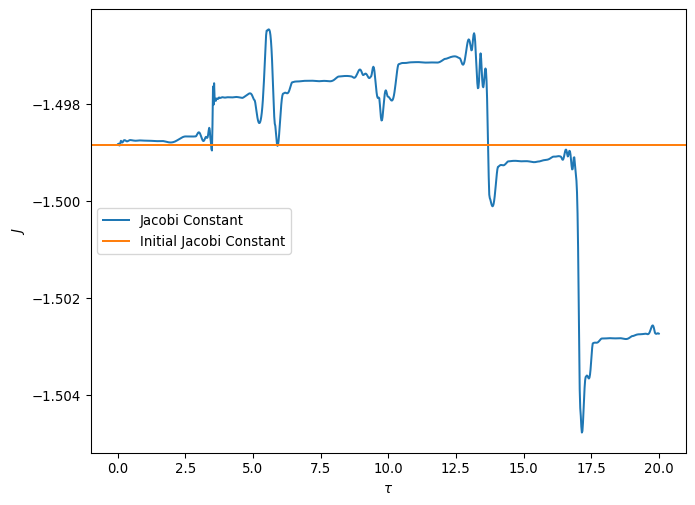

In [8]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=96)
ax.plot(sol.t, J, label="Jacobi Constant")
ax.axhline(J[0], color="C1", label="Initial Jacobi Constant")
ax.legend(loc="center left")
ax.set_xlabel("$\\tau$")
ax.set_ylabel("$J$")


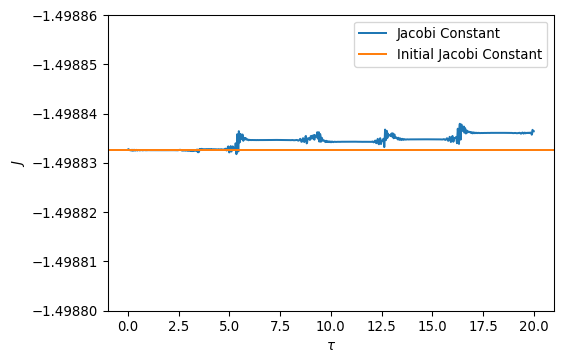

In [9]:
sol_hp = solve_ivp(nondim_cr3bp, [t_0, t_f], Y_0, atol=1e-9, rtol=1e-6, t_eval=t_points)
Y_hp = sol_hp.y.T
r_hp = Y_hp[:, :3]  # nondimensional distance
v_hp = Y_hp[:, 3:]  # nondimensional velocity

speed_sq_hp = np.sum(np.square(v_hp), axis=1)

r_hp[:, 0] += pi_2
sigma_hp = np.sqrt(np.sum(np.square(r_hp), axis=1))
r_hp[:, 0] -= 1
psi_hp = np.sqrt(np.sum(np.square(r_hp), axis=1))
r_hp[:, 0] = r_hp[:, 0] + 1 - pi_2

J_hp = (
    0.5 * speed_sq_hp
    - (1 - pi_2) / sigma_hp
    - pi_2 / psi_hp
    - 0.5 * ((1 - pi_2) * sigma_hp**2 + pi_2 * psi_hp**2)
)

fig, ax = plt.subplots(figsize=(6, 4), dpi=96)
ax.plot(sol_hp.t, J_hp, label="Jacobi Constant")
ax.axhline(J_hp[0], color="C1", label="Initial Jacobi Constant")
ax.set_ylim(-1.4988, -1.49886)
ax.legend(loc="upper right")
ax.set_xlabel("$\\tau$")
ax.set_ylabel("$J$")
ax.ticklabel_format(style="plain", useOffset=False)

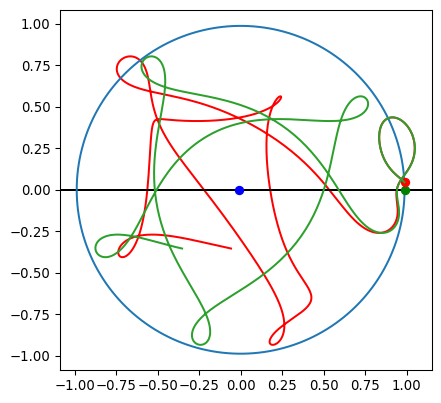

In [10]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=96)

# Plot the orbits
ax.plot(r_hp[:, 0], r[:, 1], "r", label="Reduced Tolerances Trajectory")
ax.axhline(0, color="k")
ax.plot(np.hstack((x_2, x_2[::-1])), np.hstack((y_2, -y_2[::-1])))
ax.plot(-pi_2, 0, "bo")
ax.plot(1 - pi_2, 0, "go")
ax.plot(x_0, y_0, "ro")
ax.plot(r[:, 0], r[:, 1], "C2", label="Original Trajectory")
ax.set_aspect("equal")
